# **Histopathologic Cancer Detection**

Por: Iván Darío Gómez Marín\
C.C: 1.041.147.729\
Maestría en ingeniería- Grupo ALIADO\
Correo: idario.gomez@udea.edu.co

------------------------------------------------------------------------------------------------------------------------------------------------


## **Contexto de la aplicación**

<div style="text-align: justify;">

La aplicación propuesta proviene la una competencia publicada en la platataforma Kaggle, que puede encontrarse en el siguiente link:
 [histopathologic_cancer_detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection). \
El reto de la competencia radica en **crear un algoritmo para identificarcáncer metastásico en pequeños parches de imágenes tomadas de exploraciones patológicas digitales de mayor tamaño**. Los datos para esta competición son una versión ligeramente modificada del conjunto de datos de referencia PatchCamelyon (PCam).PCam convierte la tarea clínica de detección de metástasis en una sencilla tarea de clasificación binaria de imágenes, similar a CIFAR-10 y MNIST.
</div>

## **Objetivo de ML**

<div style="text-align: justify;">

Dada una imagen etiquetada previamente indicando si se identifica tejido cancerigeno en ella, el objetivo es crear un modelo de clasificación binario que dada uma imagen permita discriminarla, indicado si hay presencia de tejido canncerígeno o no; 1 indica la presencia de tejido cancerigeno en la imagen y 0 la ausencia de este.
</div>

## **Dataset**

<div style="text-align: justify;">

El conjunto completo de imagenes disponible para el entrenamiento y validación del modelo, se puede acceder a través del siguiente link: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data. \
El conjunto de datos consiste en imágenes microscópicas de tejido de ganglios linfáticos. Cada imagen tiene una resolución de 96x96 píxeles, y la tarea consistirá en identificar tejido canceroso metastásico en una región central de la imagen de 32x32 píxeles. Según la descripción de la competencia de Kaggle, la identificación de al menos 1 píxel de tejido tumoral etiquetaría efectivamente la imagen como positiva, es decir, con cáncer. El conjunto de datos original de entrenamiento consta de **220.025 imágenes**.
**Nota:**En nuestro caso de estudio, por cuestiones pedagógicas y por temas de capacidad computacional, haremos uso de un subconjunto de **30.000 imagenes** de al cual se puede acceder con ayuda del siguiente código**:
</div>

### Lectura de datos

In [1]:
# librerias requeridas
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm,trange
import matplotlib.pyplot as plt
import gc
import os
import os, cv2
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth', None)

In [ ]:
def read_data_colab():
  from google.colab import drive
  drive.mount('/content/drive',force_remount=True)
  train_path= '/content/drive/MyDrive/DEEP LEARNING COURSE/FINAL PROJECT DL/data'
  df_id = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
  df_id['id'] = df_id.path.map(lambda x: os.path.split(x)[1].split(".")[0])
  labels = pd.read_csv('/content/drive/MyDrive/DEEP LEARNING COURSE/FINAL PROJECT DL/train_labels.csv')
  df = df_id.merge(labels, on = "id")
 df['label']= df['label'].apply(int)
  if df.empty:
    print('No se pudo leer el dataset')
  else:
    print('Lectura exitosa!')
  return df

In [ ]:
# Lectura de datos en Google Colab desde drive
#-----------------------------------------------------------------------------------------
%matplotlib inline
df=pd.DataFrame()
while df.empty:
  df= read_data_colab()
  
plt.pie(df['label'].value_counts(), labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(20,20))
plt.show()


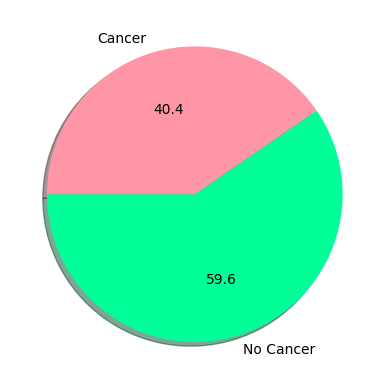

<Figure size 2000x2000 with 0 Axes>

In [11]:
# Lectura de datos locales
#-----------------------------------------------------------------------------------------
path = os.path.join(os.path.abspath(os.getcwd()), "Dataset_cancer_detection")
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')
# Creating a dataframe from the train_path filenames and lables
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df['id'] = df.path.map(lambda x: os.path.split(x)[1].split(".")[0]) 
labels = pd.read_csv("train_labels.csv", dtype={'label':'str'}) 
df = df.merge(labels, on = "id") 
df['label']= df['label'].apply(int)

%matplotlib inline
plt.pie(df['label'].value_counts(), labels=['No Cancer', 'Cancer'], startangle=180, 
         autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(20,20))
plt.show()


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    30000 non-null  object
 1   id      30000 non-null  object
 2   label   30000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 703.3+ KB


El dataset elegido está desbalanceado debido a que está conformado por **17.876 imágenes sin tejido cancerígeno** y **12.124 con tejido cancerígeno**. En el modelamiento se implementarán estrategias que permitan disminuir los efectos negativos que suele traer este desequilibrio.

In [13]:
# Función para cargar N imagenes del dataframe df
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8)
    y = np.squeeze(df['label'].iloc[0:N].values)
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
    return X,y
# Cargando 10 imagenes
N=10
X,y = load_data(N=N,df=df)

  0%|          | 0/10 [00:00<?, ?it/s]

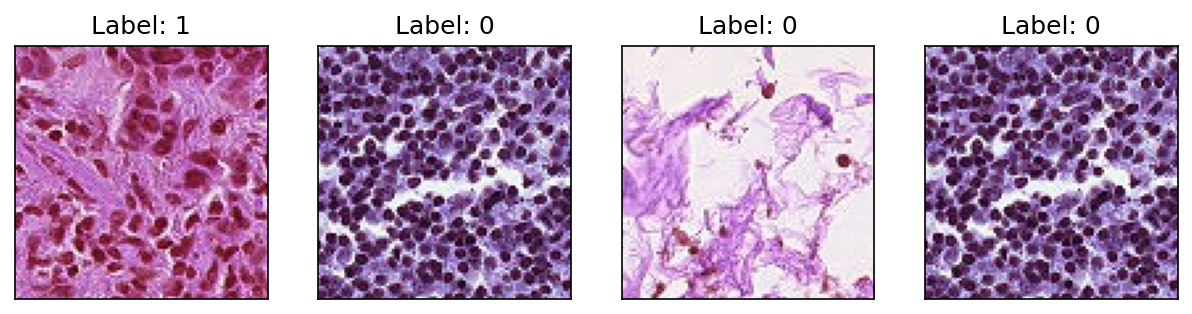

In [15]:
# Visualizando 3 imagenes de forma aleatoria
fig = plt.figure(figsize=(10, 6), dpi=150)
for plotNr,idx in enumerate(np.random.randint(0,N,4)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[])
    plt.imshow(X[idx])
    ax.set_title('Label: ' + str(y[idx]))

## **Métricas de desempeño**

En la competición, la evaluación del desempeño se hizo con base en la curva ROC;
En general cuanto más ``arriba y a la izquierda''  del diagrama se encuentre la curva ROC, mejor será el clasificador.


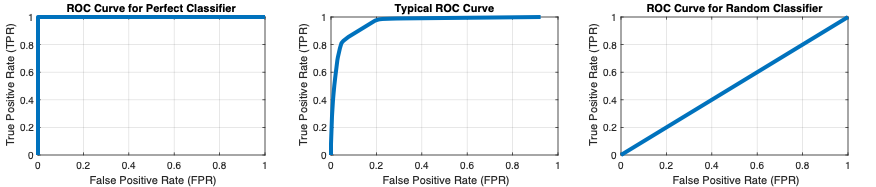

## **Referencias y resultados previos**

https://www.kaggle.com/code/walia20/histopathologic-cancer-detection-using-cnns\
https://www.kaggle.com/code/janprzybyszewski/histopathologic-cancer-detection-using-tensorflow

# CONSTRUCCIÓN DEL MODELO

In [5]:
# Carga de librerias necesarias
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Resizing, Rescaling
from keras.losses import BinaryCrossentropy
from keras.optimizers import SGD
from keras.metrics import BinaryAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
# Cargando las imagenes para el entrenamiento
N = int(np.round(df["path"].size))
X,y = load_data(N=N,df=df)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [18]:
# División del dataset en train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=123)

In [25]:
preprocess = Sequential([])
preprocess.add(Resizing(196,196,interpolation='bilinear',input_shape=(None,None,3)))
preprocess.add(Rescaling(1./255))

def get_model1(preprocess):
    model = Sequential([])
    model.add(preprocess)
    model.add(Conv2D(64,(3,3),activation='LeakyReLU'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3), activation='LeakyReLU'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(256,activation='LeakyReLU'))
    model.add(Dropout(0.15))
    model.add(Dense(128,activation='LeakyReLU'))   
    model.add(Dense(1,activation='sigmoid'))
    model.compile(
        optimizer='adam',
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy('accuracy')]
    )
    return model


In [26]:
initial_model = get_model1(preprocess)
initial_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 196, 196, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 194, 194, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 97, 97, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 70688)            

In [27]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.05,
    patience=3
)

In [28]:
history = initial_model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
657/657 [==============================] - 521s 792ms/step - loss: 0.6110 - accuracy: 0.7280 - val_loss: 0.4975 - val_accuracy: 0.7636
Epoch 2/10
657/657 [==============================] - 518s 789ms/step - loss: 0.4880 - accuracy: 0.7755 - val_loss: 0.5096 - val_accuracy: 0.7532
Epoch 3/10
657/657 [==============================] - 515s 784ms/step - loss: 0.4551 - accuracy: 0.7960 - val_loss: 0.5274 - val_accuracy: 0.7722
Epoch 4/10
657/657 [==============================] - 513s 781ms/step - loss: 0.3888 - accuracy: 0.8322 - val_loss: 0.5089 - val_accuracy: 0.7818


In [29]:
val_loss, val_acc = initial_model.evaluate(X_test,y_test)

282/282 [==============================] - 43s 151ms/step - loss: 0.5089 - accuracy: 0.7818


282/282 [==============================] - 43s 151ms/step


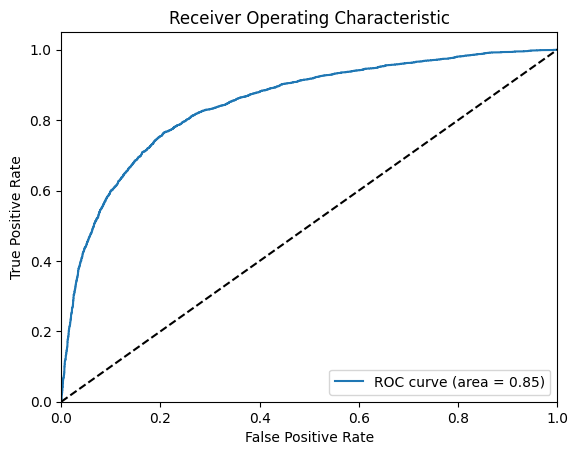

In [30]:
# Creación de la curva ROC

from sklearn.metrics import roc_curve, auc
y_pred_proba = initial_model.predict(X_test)

# Calculate FPR, TPR, and thresholds using NumPy
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Calculate AUC using scikit-learn
auc_score = auc(fpr, tpr)

# Plot ROC curve using Matplotlib
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:
from sklearn.metrics import classification_report
pred_class= [ 1 if  prob>0.5 else 0 for prob in np.ravel(y_pred_proba)]
print(classification_report(y_test, pred_class))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5363
           1       0.77      0.65      0.71      3637

    accuracy                           0.78      9000
   macro avg       0.78      0.76      0.77      9000
weighted avg       0.78      0.78      0.78      9000



# OTROS MODELOS

In [20]:
preprocess = Sequential([])
preprocess.add(Resizing(196,196,interpolation='bilinear',input_shape=(None,None,3)))
preprocess.add(Rescaling(1./255))

In [21]:
def get_model(preprocess):

    model = Sequential([])
    model.add(preprocess)
    model.add(Conv2D(16,(3,3),activation='LeakyReLU'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3),activation='LeakyReLU'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16,(3,3),activation='LeakyReLU'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Conv2D(64,(3,3),activation='relu'))
    # model.add(MaxPooling2D(strides=16,pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(300,activation='LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(256,activation='LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(
        optimizer=SGD(0.03),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy('accuracy')]
    )


    return model

In [22]:
model = get_model(preprocess)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 196, 196, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 194, 194, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 97, 97, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 95, 95, 64)        9280      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 16)       

In [23]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=5,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node 'binary_crossentropy/Cast' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ivdgo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ivdgo\AppData\Local\Temp\ipykernel_1112\3059362593.py", line 1, in <module>
      history = model.fit(
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ivdgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2421, in binary_crossentropy
      y_true = tf.cast(y_true, y_pred.dtype)
Node: 'binary_crossentropy/Cast'
Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_5169]

In [ ]:
val_loss, val_acc = model.evaluate(X_test,y_test)

29/29 [==============================] - 14s 480ms/step - loss: 0.6812 - accuracy: 0.5183
